# Brain Tumor Detection

Brain tumor detection is a critical task in medical diagnostics, as timely and accurate identification of tumors can significantly impact treatment outcomes and patient survival rates. Traditional methods for brain tumor detection often rely on manual inspection of medical images by radiologists, which can be time-consuming, subjective, and prone to human error. With the advent of deep learning and advanced image processing techniques, there has been a paradigm shift towards automated and more precise methods for medical image analysis.

One promising approach in this domain is the application of transfer learning using pre-trained convolutional neural networks (CNNs). Transfer learning leverages the knowledge gained from training on large datasets for one task and applies it to a different but related task. This method is particularly advantageous in medical imaging, where annotated datasets are often limited due to the high cost and expertise required for manual labeling.

VGG16, a well-established CNN architecture developed by the Visual Geometry Group (VGG) at the University of Oxford, has demonstrated remarkable performance in various image classification challenges. By utilizing a deep architecture consisting of 16 weight layers, VGG16 can capture intricate patterns and features within images, making it an excellent candidate for medical image analysis.

In this study, I explore the application of transfer learning with VGG16 for brain tumor detection. By fine-tuning the pre-trained VGG16 model on a dataset of brain MRI images, we aim to develop an automated system capable of accurately identifying the presence of brain tumors. This approach not only accelerates the detection process but also enhances diagnostic accuracy, thereby providing valuable support to healthcare professionals in clinical settings.

# Libraries

In [1]:
# For data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageEnhance

# For machine learning
import tensorflow as tf
from keras.layers import *
from keras.losses import *
from keras.models import *
from keras.metrics import *
from keras.optimizers import *
from keras.applications import *
from keras.preprocessing.image import load_img

# For Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.style as style
style.use('ggplot')

# Misellaneous
from tqdm import tqdm
import os
import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## DataSet Visualization
The visualization of the dataset plays a crucial role in understanding the characteristics and distribution of the data used for brain tumor detection. It helps in identifying potential biases, data quality issues, and the overall structure of the dataset, which are essential for training effective machine learning models. The scope of dataset visualization includes:

1. __Class Distribution:__
    + Visualize the distribution of different classes (e.g., types of brain tumors) to ensure a balanced dataset.
    + Identify any class imbalance issues that may need to be addressed during model training.

2. __Image Samples:__
    + Display random samples of images from each class to get a sense of the visual variations and quality of the images.
    + Show representative images of each type of tumor and healthy brain images.

3. __Image Dimensions and Formats:__
    + Check the consistency of image dimensions and formats to ensure they are suitable for feeding into the neural network.
    + Visualize any preprocessing steps such as resizing, normalization, and augmentation.

__Dataset URL__

+ [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)


Found 5712 images in 4 labels.

The first 5 images in the training set are:
['notumor', 'pituitary', 'meningioma', 'pituitary', 'pituitary']


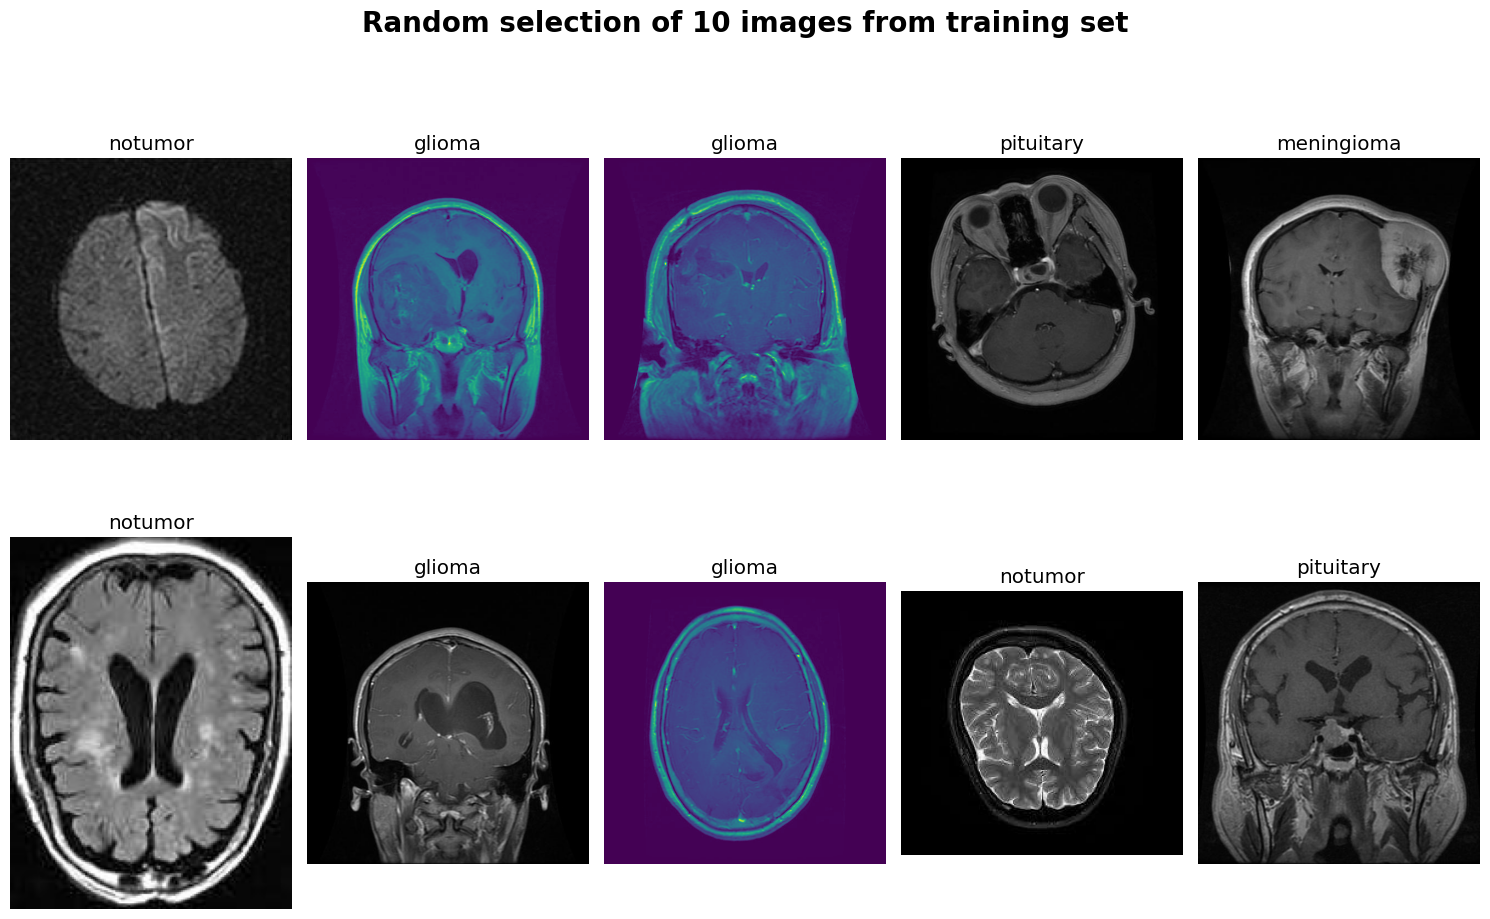

In [2]:
# Define the relative paths
relative_path_train=os.path.join('brain-tumor-mri-dataset', 'Training')
relative_path_test=os.path.join('brain-tumor-mri-dataset', 'Testing')

# Get the base directory of the current script
base_dir=os.path.dirname(os.path.abspath('brain_tumor_detection.ipynb'))
train_dir=os.path.join(base_dir, relative_path_train)
test_dir=os.path.join(base_dir, relative_path_test)

# Initialize lists to store image paths and labels
train_paths=[]
train_labels=[]

# Ensure the training directory exists
if not os.path.exists(train_dir):
    print(f"Training path does not exist: {train_dir}")
else:
    # Traverse subdirectories and files within the training directory
    for label in os.listdir(train_dir):
        label_path=os.path.join(train_dir, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path=os.path.join(label_path, image)
                if os.path.isfile(image_path):
                    train_paths.append(image_path)
                    train_labels.append(label)

    # Shuffle the data
    train_paths, train_labels=shuffle(train_paths, train_labels)

    print(f"Found {len(train_paths)} images in {len(set(train_labels))} labels.")
    num_train_labels=5
    print(f'\nThe first {num_train_labels} images in the training set are:\n{train_labels[:num_train_labels]}')
    
    # Randomly select 10 images
    sample_indices=random.sample(range(len(train_paths)), 10)
    sample_paths=[train_paths[i] for i in sample_indices]
    sample_labels=[train_labels[i] for i in sample_indices]
    
    # Display the images and their labels
    plt.figure(figsize=(15, 10))
    for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
        img=mpimg.imread(path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    
    plt.suptitle('Random selection of 10 images from training set', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

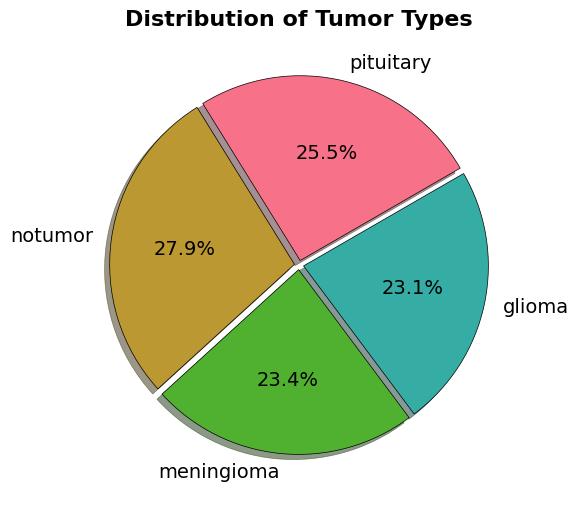

In [3]:
# Example data for labels and counts
labels=['pituitary', 'notumor', 'meningioma', 'glioma']
counts=[
    len([x for x in train_labels if x == 'pituitary']),
    len([x for x in train_labels if x == 'notumor']),
    len([x for x in train_labels if x == 'meningioma']),
    len([x for x in train_labels if x == 'glioma'])
]

# Setting Seaborn color palette
sns.set_palette("husl")

# Setting up the figure and size
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})

# Pie chart using Seaborn
plt.pie(counts,
        labels=labels,
        autopct='%.1f%%',
        startangle=30,
        wedgeprops={'edgecolor': 'black'},  # Adding black edges to wedges
        explode=(0.025, 0.025, 0.025, 0.025),  # Exploding the wedges
        shadow=True)  # Adding shadows to wedges

# Title of the chart
plt.title('Distribution of Tumor Types', fontsize=16, fontweight='bold')

# Displaying the chart
plt.show()

* The dataset is balanced

In [4]:
test_paths=[]
test_labels=[]

for label in os.listdir(test_dir):
        label_path=os.path.join(test_dir, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path=os.path.join(label_path, image)
                if os.path.isfile(image_path):
                    test_paths.append(image_path)
                    test_labels.append(label)

# Shuffle the data
test_paths, test_labels=shuffle(test_paths, test_labels)

num_test_labels=5
print(f'\nThe first {num_test_labels} images in the Testing set are:\n{test_labels[:num_test_labels]}')


The first 5 images in the Testing set are:
['meningioma', 'meningioma', 'notumor', 'pituitary', 'meningioma']


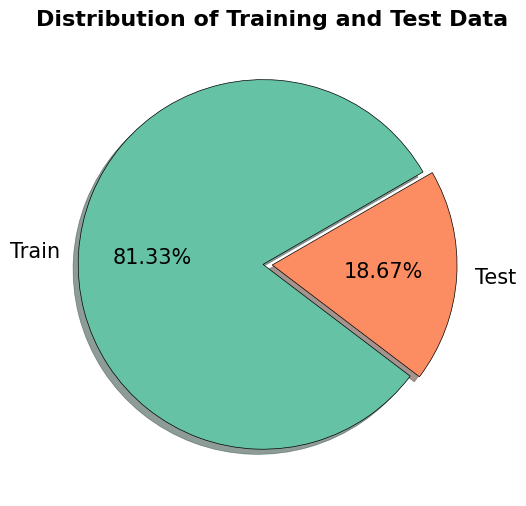

In [5]:
# Seatting Seaborn color palette
colors=sns.color_palette('Set2')    # Selecting a Seaborn color palette
sns.set_palette(colors)

# Setting up the figure and size
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size':15})

# Pie chart 
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train', 'Test'],
        autopct='%.2f%%',
        explode=(0.05, 0),
        startangle=30,
        wedgeprops={'edgecolor':'black'},   # Adding black edges to the wedges
        shadow=True)    # True shadows to the wedges

# Title of the chart
plt.title('Distribution of Training and Test Data', fontsize=16, fontweight='bold')
plt.show()

## 3. Data Augmentation
Data augmentation is a crucial technique in training deep learning models, especially when working with limited datasets. The primary purpose of data augmentation is to artificially increase the size and diversity of the training dataset by applying various transformations to the existing images. This helps in improving the robustness and generalization capability of the model. Specifically, for brain tumor detection using MRI images, data augmentation can help the model become more resilient to variations in image brightness, contrast, orientation, and other factors, which are common in real-world medical imaging.

By augmenting the dataset, we aim to:

1. __Reduce Overfitting:__ By exposing the model to a wider variety of augmented images, we help it generalize better to new, unseen data, rather than memorizing the training set.
2. __Enhance Model Robustness:__ Augmented images simulate different real-world conditions, making the model more robust to variations in image acquisition and processing.
3. __Balance Class Distribution:__ In cases of class imbalance, data augmentation can generate more samples for underrepresented classes, helping the model learn more effectively from these classes.

In [6]:
def augment_image(image):
    image=Image.fromarray(np.uint8(image))
    image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image=np.array(image)/255.0
    return image

* Let's plot some Samples:

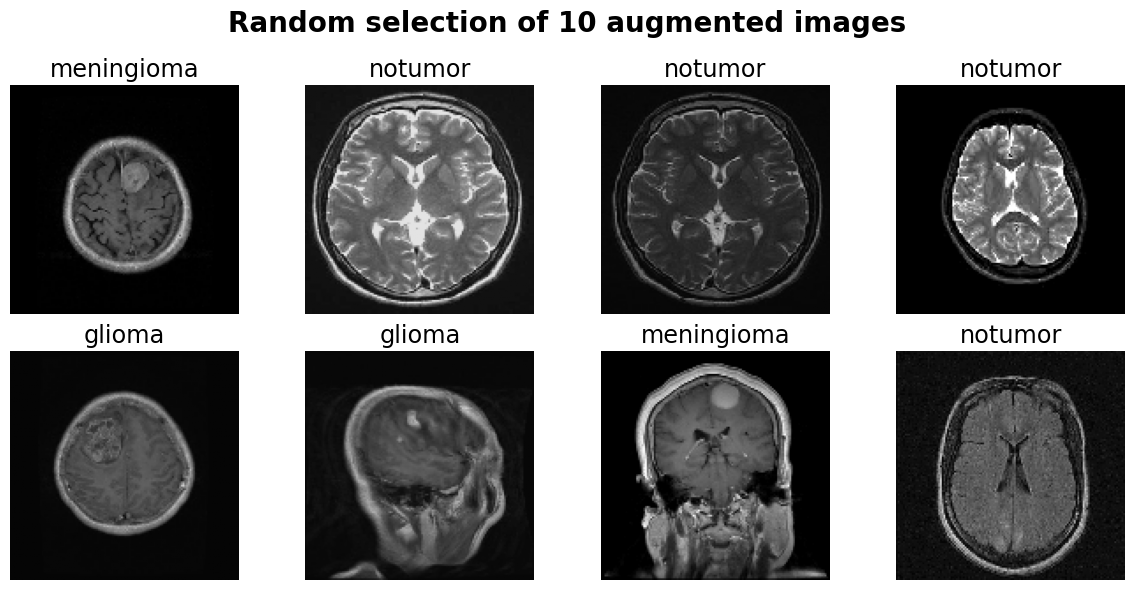

In [11]:
IMAGE_SIZE=130

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the
    images as arrays (after augmenting them)
    '''
    images=[]
    for path in paths:
        image=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image=augment_image(image)
        images.append(image)
    return np.array(images)

images=open_images(train_paths[50: 59])
labels=train_paths[50: 59]
fig=plt.figure(figsize=(12, 6))

for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    image_name=os.path.basename(os.path.dirname(labels[x]))
    plt.title(image_name)
    plt.imshow(images[x])
plt.rcParams.update({'font.size':12})
plt.suptitle('Random selection of 10 augmented images', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Generator
In deep learning, particularly when working with large image datasets, it is essential to efficiently manage and preprocess data during model training. A data generator serves this purpose by providing a steady stream of data batches to the training algorithm, handling tasks such as data loading, preprocessing, and augmentation on-the-fly. This approach not only optimizes memory usage but also enhances the overall training process by continuously supplying the model with fresh, diverse data.

The provided code implements a custom data generator for brain tumor detection, designed to yield batches of images and their corresponding encoded labels. This generator is crucial for managing large datasets that cannot fit entirely into memory and for applying real-time data augmentation.

The datagen function:

+ Iterates over the dataset for a specified number of epochs.
+ Splits the data into batches of a given size (batch_size).
+ Loads and preprocesses images using a helper function open_images.
+ Encodes the corresponding labels.
+ Yields batches of images and their encoded labels to the training algorithm.

In [13]:
unique_labels=os.listdir(train_dir)

def encode_label(labels):
    encoded=[]
    for i in labels:
        encoded.append(unique_labels.index(i))
    return np.array(encoded)

def decode_label(labels):
    decoded=[]
    for i in labels:
        decoded.append(unique_labels[i])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths=paths[i: i+batch_size]
            batch_images=open_images(batch_paths)
            batch_labels=labels[i: i+batch_size]
            batch_labels=encode_label(batch_labels)
            yield batch_images, batch_labels

## 5. The model
In the context of deep learning for image classification tasks like brain tumor detection, designing an effective neural network architecture is crucial for achieving accurate and robust predictions. The provided code snippet outlines the construction of a convolutional neural network (CNN) model using transfer learning with VGG16 as a base model.

This architecture leverages transfer learning from VGG16 to exploit its powerful feature extraction capabilities, while fine-tuning specific layers allows it to adapt to the nuances of brain tumor images. The model is designed to classify images into different types of brain tumors based on the learned features, aiming to provide accurate and reliable predictions for medical diagnostics.

In [14]:
base_model=VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all the layers to non-trainable
for layer in base_model.layers:
    layer.trainable=False

# Set the last vgg block to trainable
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

model=Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

## 6. Train model
In machine learning, training a model involves feeding data into the model, optimizing its parameters (weights and biases) based on the input data and expected outputs (labels), and evaluating its performance over multiple iterations (epochs). The provided code snippet outlines the process of training a neural network model for brain tumor detection using the previously defined architecture and data generator.

This section manages the core process of training a neural network model using the defined architecture and dataset. It encompasses setting up batch processing, iterating through epochs, and monitoring the model's performance metrics over time, providing insights into how well the model is learning from the data.

In [21]:
batch_size=20
steps=int(len(train_paths)/batch_size)
epochs=4
history=model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs), epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
285/285 ━━━━━━━━━━━━━━━━━━━━ 143s 493ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7424
Epoch 2/4
285/285 ━━━━━━━━━━━━━━━━━━━━ 138s 486ms/step - loss: 0.2762 - sparse_categorical_accuracy: 0.9026
Epoch 3/4
285/285 ━━━━━━━━━━━━━━━━━━━━ 143s 503ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9365
Epoch 4/4
285/285 ━━━━━━━━━━━━━━━━━━━━ 133s 467ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9597


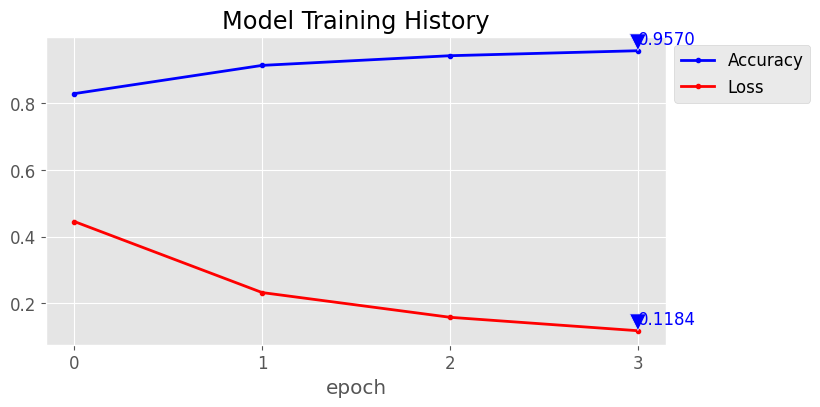

In [24]:
plt.figure(figsize=(8, 4))
plt.grid(True)

accuracy=history.history['sparse_categorical_accuracy']
loss=history.history['loss']

plt.plot(accuracy, '.b-', linewidth=2)
plt.plot(loss, '.r-', linewidth=2)

plt.annotate(f'{accuracy[-1]:.4f}', xy=(len(accuracy)-1, accuracy[-1]),
             xytext=(len(accuracy)-1, accuracy[-1]+0.02),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=12, color='blue')
plt.annotate(f'{loss[-1]:.4f}', xy=(len(loss)-1, loss[-1]),
             xytext=(len(loss)-1, loss[-1]+0.02),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=12, color='blue')

plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([i for i in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## 7. Evaluate Model with Test Samples
In ML, evaluating a model's performance on unseen test data is crucial to assess its generalization ability and predictive accuracy. The provided code snippet outlines the process of evaluating a neural network model trained for brain tumor detection using test samples.

This section encapsulates the process of applying the trained neural network model to unseen test data (`test_paths` and `test_labels`), collecting predictions, and comparing them against the ground truth labels for evaluation purposes. Evaluating the model with test samples provides insights into its real-world performance and helps validate its effectiveness in detecting brain tumors based on medical imaging data.

In [25]:
batch_size=32
steps=int(len(test_paths)/batch_size)
y_pred=[]
y_true=[]
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred=model.predict(x)
    pred=np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


  2%|▎         | 1/40 [00:01<00:48,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


  5%|▌         | 2/40 [00:02<00:40,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


  8%|▊         | 3/40 [00:03<00:37,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 10%|█         | 4/40 [00:04<00:35,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 12%|█▎        | 5/40 [00:05<00:35,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 15%|█▌        | 6/40 [00:06<00:33,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 18%|█▊        | 7/40 [00:07<00:32,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 20%|██        | 8/40 [00:08<00:31,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 22%|██▎       | 9/40 [00:08<00:30,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 25%|██▌       | 10/40 [00:10<00:29,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 28%|██▊       | 11/40 [00:10<00:28,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 30%|███       | 12/40 [00:11<00:27,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 32%|███▎      | 13/40 [00:12<00:26,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 35%|███▌      | 14/40 [00:14<00:26,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 38%|███▊      | 15/40 [00:15<00:25,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 40%|████      | 16/40 [00:15<00:23,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 42%|████▎     | 17/40 [00:16<00:22,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 45%|████▌     | 18/40 [00:17<00:21,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 48%|████▊     | 19/40 [00:18<00:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 50%|█████     | 20/40 [00:19<00:19,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 52%|█████▎    | 21/40 [00:20<00:18,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 55%|█████▌    | 22/40 [00:21<00:17,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 57%|█████▊    | 23/40 [00:22<00:16,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 60%|██████    | 24/40 [00:23<00:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 62%|██████▎   | 25/40 [00:24<00:14,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 65%|██████▌   | 26/40 [00:25<00:13,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 68%|██████▊   | 27/40 [00:26<00:12,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 70%|███████   | 28/40 [00:27<00:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 72%|███████▎  | 29/40 [00:28<00:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 75%|███████▌  | 30/40 [00:29<00:10,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 78%|███████▊  | 31/40 [00:30<00:08,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 80%|████████  | 32/40 [00:31<00:07,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 82%|████████▎ | 33/40 [00:32<00:06,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 85%|████████▌ | 34/40 [00:33<00:05,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 88%|████████▊ | 35/40 [00:34<00:04,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 90%|█████████ | 36/40 [00:35<00:03,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 92%|█████████▎| 37/40 [00:36<00:02,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 95%|█████████▌| 38/40 [00:37<00:01,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 98%|█████████▊| 39/40 [00:38<00:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


100%|██████████| 40/40 [00:39<00:00,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


41it [00:40,  1.01it/s]                        


__Classification report__<br><br>
The classification_report function generates a comprehensive report summarizing the performance of a classification model. It compares the predicted labels (`y_pred`) against the true labels (`y_true`) and computes various metrics to evaluate the model's accuracy and effectiveness in classifying the data.

In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94       300
  meningioma       0.90      0.92      0.91       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.95      1.00      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



__Confusion matrix__<br><br>
The provided code snippet is used to generate and visualize a confusion matrix for evaluating the performance of a classification model on a test dataset.

Interpretation:

- The confusion matrix heatmap provides a visual representation of how well the model predicts each class label compared to the actual labels.
- Darker shades indicate higher counts in corresponding cells, representing correct predictions, while lighter shades indicate misclassifications.
- The x-axis (`Predicted`) and y-axis (`Actual`) show the class labels, allowing easy interpretation of where the model tends to perform well or poorly.

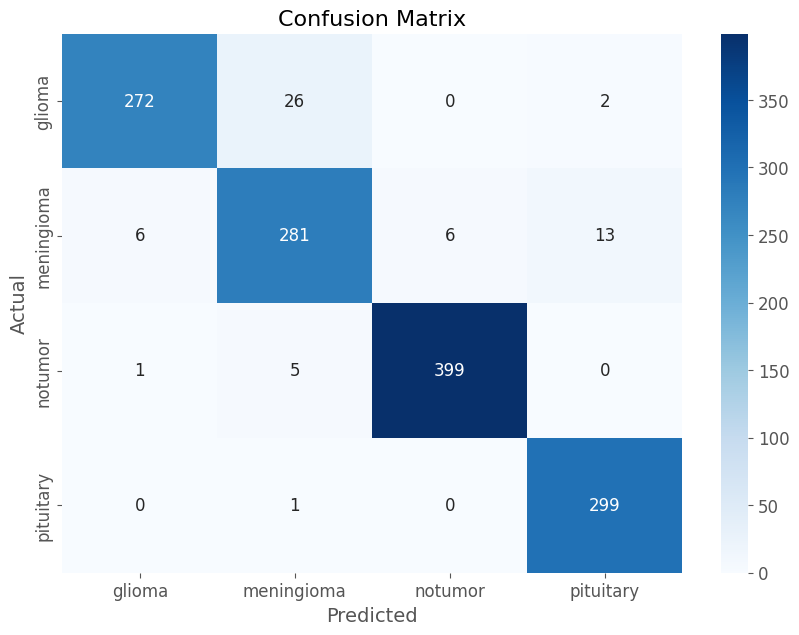

In [32]:
class_names=[name for name in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, name))]

cm=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_names, yticklabels=class_names, 
            annot_kws={'size': 12})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()